In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import os
import sys
# from tsbootstrap import MovingBlockBootstrap, CircularBlockBootstrap
from arch.bootstrap import StationaryBootstrap, CircularBlockBootstrap
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from functools import reduce 

parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)

from utils.db_utils import df_from_snowflake
pd.option_context('display.max_rows', None,)
pp.style.use('ggplot')

In [56]:
def decompose_seasonality(data,revenue_column):
    """return residuals from decomposition process"""
    stl = STL(data.iloc[:, revenue_column], period=365, seasonal=13, robust=True) 
    result = stl.fit()
    return result.resid, result.trend, result.seasonal 

def make_bootstrap(data: np.array, bootstrap_time: int=100):
    dc = []
    sample_size = data.shape[0]
    idx = [i for i in range(sample_size)]
    # loop through the required number of bootstraps
    for b in range(bootstrap_time):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        b_samp = data[sidx]
        
        # store results
        dc.append(b_samp)
        df = pd.DataFrame(np.array([dc][:][:][0])).T
    return(df)

def processing(data,date_column,revenue_column):
    rediduals, trend, seasonal = decompose_seasonality(data, revenue_column)
    bootstrapped_residuals = make_bootstrap(rediduals,bootstrap_time=20)
    df = (bootstrapped_residuals.T + trend + seasonal).T
    return df


def exponential_smoothing(data,date_column,revenue_column):

    max_date_data = data.iloc[:, date_column].max() 
    first_date = max_date_data.replace(day=1)
    end_date = first_date + pd.offsets.MonthEnd(0)

    x = (end_date - pd.to_datetime(first_date))

    data = data[(data.iloc[:, date_column] < first_date)]

    tes_model = ExponentialSmoothing(data.iloc[:, revenue_column],
                                    trend="add",
                                    seasonal="add",
                                    damped_trend=True,
                                    seasonal_periods=7).fit()

    y_pred = tes_model.forecast(x.days+1)

    df_prediction = pd.DataFrame(pd.date_range(start=first_date, end=end_date), columns=['DATE'])
    # df_prediction = pd.DataFrame()
    # df_prediction['DATE'] = data.iloc[:, date_column]
    df_prediction['prediction_value'] = y_pred.reset_index(drop=True)
    # df_prediction.set_index('DATE', inplace=True)
    # monthly_revenue = df_prediction.resample('M').sum()
    # monthly_revenue.reset_index(inplace=True)

    return df_prediction


In [37]:
with open ('query_dcs_input_data.sql', 'r') as sql_file:
    raw_revenues = df_from_snowflake(sql_file.read())

In [38]:
filtered_df = raw_revenues[(raw_revenues['SITE_GLOBAL_REGION'] == 'DACH') & (raw_revenues['SITE_ID'].str.contains('.de'))]
filtered_df['DATE'] = pd.to_datetime(filtered_df['DATE'])
grouped_df = filtered_df.groupby('DATE').agg({'BOOKING_REVENUES': lambda x: round(x.sum(), 0)}).reset_index()
sorted_df = grouped_df.sort_values(by='DATE')

In [57]:
bootstrap = processing(sorted_df,0,1)
cols = ['DATE'] + bootstrap.columns.tolist()
bootstrap['DATE'] = pd.to_datetime(sorted_df['DATE'])
bootstrapped_data = bootstrap[cols]

In [58]:
bootstrapped_data

,DATE,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,2020-01-01,22697.462775,27717.755053,32004.464018,18732.889351,32411.704315,22460.145327,20813.111222,22267.058033,22267.058033,...,21883.967930,26784.194067,11836.270391,28904.984659,19751.055072,25471.542046,363.077937,37663.013551,24158.362965,14297.507960
1,2020-01-02,38180.133502,28238.858067,31793.061333,34851.932163,35558.581431,25845.371933,25517.778316,7172.442254,29688.863243,...,81954.662585,31865.008018,38099.817280,30618.034340,34036.838218,42241.358124,66715.854165,34008.818751,33262.189788,27946.372895
2,2020-01-03,35292.396060,29733.124384,35699.079281,25758.029949,40364.490638,41544.427380,34888.820330,33631.636031,77829.542062,...,32892.789509,34950.437285,30059.426535,28983.367488,115884.900252,27685.486557,37455.578737,21426.312956,26706.551561,33328.659793
3,2020-01-04,49642.848233,41016.964072,6469.071146,48839.526957,82576.101153,43110.192018,44452.232681,41183.748190,46805.753826,...,42764.318636,45818.905528,39872.756053,38461.187886,35115.719611,63706.790449,61200.149820,41163.136270,18856.623525,40269.005018
4,2020-01-05,60612.841713,60520.178009,65005.863351,62514.156123,47189.227426,65575.298258,59541.697528,68194.763649,155981.604039,...,63429.171439,64034.768100,115556.377523,56902.066265,61065.732434,60753.859121,63732.969099,67796.339431,105967.971788,44623.950084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,2024-07-11,58806.899962,55722.749941,125655.668776,57620.347155,58092.023623,51091.453721,56858.825904,54692.862273,51310.407724,...,54966.794459,55527.546741,48138.567481,9920.502725,58522.980587,52941.319476,51160.273106,56074.834481,56775.164987,43361.535448
1654,2024-07-12,50411.687824,59835.780907,57518.209270,61372.403537,69368.657709,61974.769121,66615.669285,41204.508050,56394.396290,...,8165.480154,58689.109299,61018.702737,63569.843577,69370.432238,84405.998135,69967.041210,61400.206491,30564.771812,60744.866586
1655,2024-07-13,47999.195714,56090.628217,68144.426345,58582.179594,69725.783867,44688.214067,60474.542105,60118.846304,60553.299514,...,59489.030106,62095.427788,84997.431861,58122.815482,36774.953214,53311.003557,56255.148564,57046.445633,43239.971935,64438.771535
1656,2024-07-14,76089.382515,77359.377291,83382.957672,96505.616767,79297.139126,81349.990690,82800.870114,82593.190115,80764.377379,...,88058.581402,79117.838348,60871.197412,71299.678424,78203.126057,97430.184602,82562.404731,79197.519785,82548.510139,76724.127579


In [ ]:

output_df = []

for i in range(1, len(bootstrapped_data.columns)):
    result = exponential_smoothing(bootstrapped_data, 0, i)
    result = result.rename(columns={'prediction_value': f'prediction_value{i}'})
    output_df.append(result)
    

merge_df = reduce(lambda left, right: pd.merge(left,right, on='DATE'), output_df)

In [ ]:
merge_df

# RESET
### evaluate predicted data from DWH

In [196]:
sql = """select * from dev.reporting_finance.dcs_exponetial_smoothing"""
estimations = df_from_snowflake(query=sql)

In [197]:
estimations.iloc[:,1:].sum(axis=0).mean()

4885292.911731022

Text(0.5, 0, 'million')

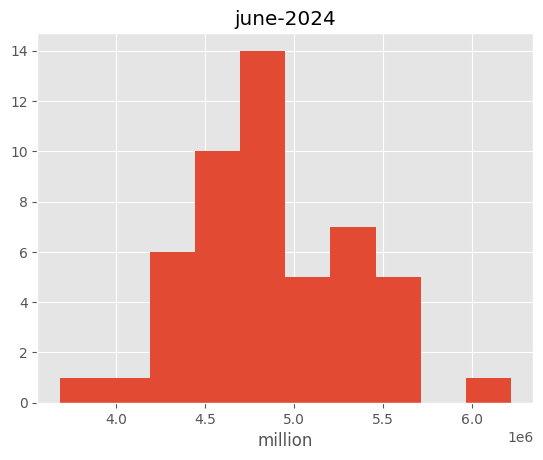

In [198]:
hist = estimations.iloc[:,1:].sum(axis=0)
pp.hist(hist)
pp.title('june-2024')
pp.xlabel('million')

In [199]:
import scipy.stats as st 

def mean_confidence_interval(data, confidence=0.95):
    lens = len(data)
    mean = []
    lower = []
    upper = []
    for row in range(0,lens):
        a = 1.0 * np.array(data.iloc[row,:])
        n = len(a)
        m, se = np.mean(a), st.sem(a)
        std = st.tstd(a)
        # l, u = st.norm.interval(confidence=0.99, 
        #          loc=np.mean(a), 
        #          scale=st.sem(a)) 

        mean.append(m)
        lower.append(m-std)
        upper.append(m+std)
    return mean, lower, upper

In [200]:
mean, lower, upper = mean_confidence_interval(estimations.iloc[:,1:])

In [156]:
actual = """
select date,
       sum(booking_revenues) actual_revenue
from stage.reporting_finance.dcs_input_data
where contains(site_id, '.de')
and site_global_region= 'DACH'
and date between '2024-06-01' and ' 2024-06-30'
group by 1
order by 1 asc
"""
actual_df = df_from_snowflake(query=actual)

In [157]:
actual_df.set_index('DATE',inplace=True)


In [182]:
actual_df.sum()

ACTUAL_REVENUE    4.554400e+06
dtype: float64

In [201]:
plot_df = pd.DataFrame()
plot_df['DATE']= pd.to_datetime(estimations['date'])
plot_df['mean']= np.array(mean).cumsum()
plot_df['upper'] = np.array(upper).cumsum()
plot_df['lower'] = np.array(lower).cumsum()
plot_df.set_index('DATE',inplace=True)

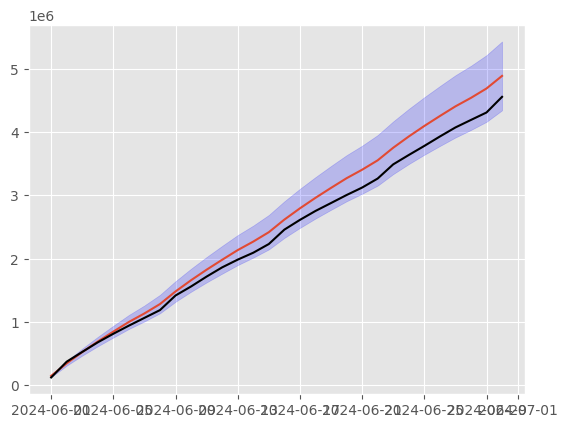

In [202]:
_,ax = pp.subplots(sharex=True)

ax.plot(plot_df['mean'], label='pred')
ax.fill_between(plot_df.index,
                np.array(plot_df['lower']),
                np.array(plot_df['upper']),
                alpha=0.2,
                color='blue'
                )
ax.plot(actual_df['ACTUAL_REVENUE'].cumsum(), label='actual', color='black')

In [133]:
plot_df.index

DatetimeIndex(['2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04',
               '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08',
               '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
               '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16',
               '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20',
               '2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', name='DATE', freq=None)

# Playaround

In [ ]:
with open ('query_dcs_input_data.sql', 'r') as sql_file:
    raw_revenues = df_from_snowflake(sql_file.read())

In [47]:
raw_revenues.sort_values('DATE', inplace=True)
raw_revenues.reset_index(inplace=True)
raw_revenues.drop(['index'],axis=1,inplace=True)

In [48]:
raw_revenues

,DATE,SITE_ID,LEGAL_ENTITY,SITE_GLOBAL_REGION,INTER_COMPANY_GROUP,DEAL_TYPE,SESSIONS,SPEND,BOOKING_QUANTITY,BOOKING_REVENUES,BOOKING_REVENUES_AFTER_CANCELLATIONS,IFRS_REVENUES,BOOKING_QUANTITY_PREVIOUS_DAY
0,2020-01-01,hometogo.de,hometogo,DACH,False,Onsite - CPA,233408,63167.53704,318,29436.520190,17924.073722,14.686338,318
1,2020-01-02,hometogo.de,hometogo,DACH,False,Onsite - CPA,237618,70612.83003,341,32583.372330,20186.775787,159.724437,341
2,2020-01-03,hometogo.de,hometogo,DACH,False,Onsite - CPA,239338,68416.83851,394,36031.080940,22667.737360,0.000000,394
3,2020-01-04,hometogo.de,hometogo,DACH,False,Onsite - CPA,243631,66523.13477,397,44482.174150,27406.345807,160.678364,397
4,2020-01-05,hometogo.de,hometogo,DACH,False,Onsite - CPA,320253,91585.67646,561,57115.776030,33483.496511,53.774908,561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,2024-07-11,hometogo.de,hometogo,DACH,False,Onsite - CPA,173085,41492.06322,473,55509.648100,44036.479540,234.641720,473
1654,2024-07-12,hometogo.de,hometogo,DACH,False,Onsite - CPA,164408,41390.92561,509,61748.132650,48600.120973,162.398716,509
1655,2024-07-13,hometogo.de,hometogo,DACH,False,Onsite - CPA,164586,45641.09732,537,62467.291040,49744.190036,184.606935,537
1656,2024-07-14,hometogo.de,hometogo,DACH,False,Onsite - CPA,231777,61824.63228,748,87034.550312,69654.837955,152.919000,748


In [49]:
df = raw_revenues['BOOKING_REVENUES']
date = raw_revenues['DATE']

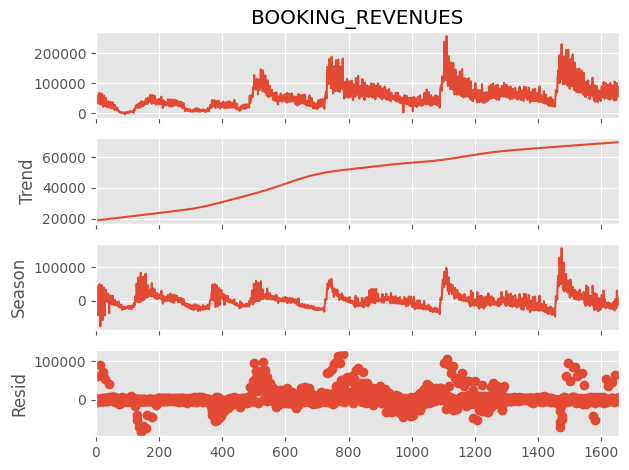

In [50]:
# decompose
stl = STL(raw_revenues['BOOKING_REVENUES'], period=365, seasonal=13, robust=True) 
result = stl.fit()
result.plot()
pp.show()

In [ ]:
result.resid + result.trend + result.seasonal 

In [175]:
# n_bootstraps = 1000
# block_length = 2
# rng = 42
# mbb = CircularBlockBootstrap(n_bootstraps=n_bootstraps, rng=rng, block_length=block_length)

# # Generate bootstrapped samples
# return_indices = False
# bootstrapped_samples = mbb.bootstrap(
#     df, return_indices=return_indices)

# # Collect bootstrap samples
# X_bootstrapped = []
# for data in bootstrapped_samples:
#     X_bootstrapped.append(data)

# X_bootstrapped = np.array(X_bootstrapped)


In [38]:
# # bootstrap residuals
# cbb = CircularBlockBootstrap(24, result.resid, seed=42)
# tmp = []
# for data in cbb.bootstrap(20):
#     tmp.append(data[0][0].reset_index(drop=True))

# X_bootstrapped = pd.concat(tmp, axis=1, ignore_index=True) 

In [94]:
X_bootstrapped = make_bootstrap(result.resid,n_bootstraps=10)
# pd.DataFrame(np.array([X_bootstrapped][:][:][0])).T

In [96]:
# add back trend and seasonal components to get bootstrapped original data
X_bootstrapped = (X_bootstrapped.T + result.trend + result.seasonal ).T
X_bootstrapped

,0,1,2,3,4,5,6,7,8,9
0,-8644.091264,21526.039496,26429.543800,23441.756288,16026.901441,19609.537835,20811.614920,26280.554450,-48443.264717,26555.195160
1,24512.067563,28074.501880,46709.984817,33865.373786,33061.368526,4296.008996,32282.375754,63573.188042,37520.549141,4611.840574
2,30321.013718,46877.148977,39342.380806,71509.507306,60488.670471,27336.171472,73216.463685,34915.190075,26698.022231,34274.375429
3,47480.416466,45317.804473,43894.371425,38460.914409,49879.631399,52679.204193,111290.896922,39872.427015,42428.788598,110815.027760
4,62257.751993,59428.796765,62687.161079,65818.633701,90318.821892,60055.487453,69625.521506,64890.288142,64244.003159,72643.981056
...,...,...,...,...,...,...,...,...,...,...
1653,62912.826496,54531.337069,57503.085894,62268.447869,58143.915608,72085.357319,53725.491684,56675.446934,55238.270737,62286.913364
1654,63832.743450,60721.543249,54492.409066,60576.540893,57645.803911,76157.434281,62476.289078,64223.778936,28292.242898,58270.667956
1655,58137.036470,50994.491074,58571.460349,73275.593075,-12381.836740,50792.627360,58142.602441,31013.138254,66851.345992,53021.030048
1656,77199.178007,82886.868309,71257.768623,75125.010307,84473.018633,99093.061517,99093.061517,110589.712875,80222.521136,82106.791684


In [ ]:
# pd.DataFrame(np.hstack(X_bootstrapped))

In [97]:
joined_df = pd.merge(pd.DataFrame(date), pd.DataFrame(X_bootstrapped), how='left', left_index=True, right_index=True)
joined_df['mean'] = joined_df.iloc[:,1:20].mean(axis=1)
joined_df['actual'] = raw_revenues['BOOKING_REVENUES']

In [98]:
joined_df

,DATE,0,1,2,3,4,5,6,7,8,9,mean,actual
0,2020-01-01,-8644.091264,21526.039496,26429.543800,23441.756288,16026.901441,19609.537835,20811.614920,26280.554450,-48443.264717,26555.195160,12359.378741,29436.520190
1,2020-01-02,24512.067563,28074.501880,46709.984817,33865.373786,33061.368526,4296.008996,32282.375754,63573.188042,37520.549141,4611.840574,30850.725908,32583.372330
2,2020-01-03,30321.013718,46877.148977,39342.380806,71509.507306,60488.670471,27336.171472,73216.463685,34915.190075,26698.022231,34274.375429,44497.894417,36031.080940
3,2020-01-04,47480.416466,45317.804473,43894.371425,38460.914409,49879.631399,52679.204193,111290.896922,39872.427015,42428.788598,110815.027760,58211.948266,44482.174150
4,2020-01-05,62257.751993,59428.796765,62687.161079,65818.633701,90318.821892,60055.487453,69625.521506,64890.288142,64244.003159,72643.981056,67197.044675,57115.776030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,2024-07-11,62912.826496,54531.337069,57503.085894,62268.447869,58143.915608,72085.357319,53725.491684,56675.446934,55238.270737,62286.913364,59537.109297,55509.648100
1654,2024-07-12,63832.743450,60721.543249,54492.409066,60576.540893,57645.803911,76157.434281,62476.289078,64223.778936,28292.242898,58270.667956,58668.945372,61748.132650
1655,2024-07-13,58137.036470,50994.491074,58571.460349,73275.593075,-12381.836740,50792.627360,58142.602441,31013.138254,66851.345992,53021.030048,48841.748832,62467.291040
1656,2024-07-14,77199.178007,82886.868309,71257.768623,75125.010307,84473.018633,99093.061517,99093.061517,110589.712875,80222.521136,82106.791684,86204.699261,87034.550312


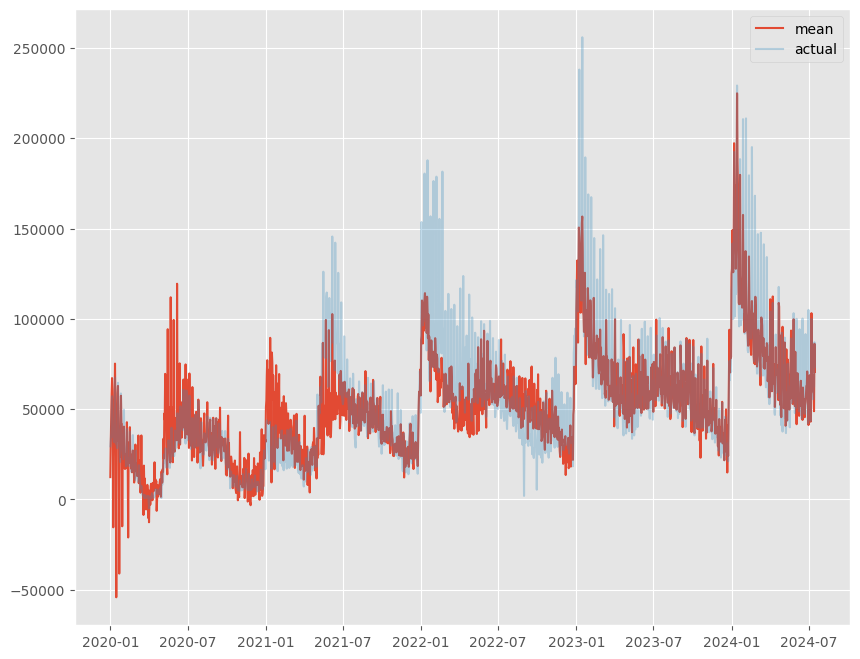

In [99]:
_, ax = pp.subplots(ncols=1, nrows=1, figsize=(10,8))
ax.plot(joined_df['DATE'], joined_df['mean'], label='mean')
ax.plot(joined_df['DATE'], joined_df['actual'], label='actual', alpha=0.3)
ax.legend()

In [2]:
import numpy as np
np.arange(3)

array([0, 1, 2])

In [9]:
indices = np.random.randint(150, size=50)
indices

array([ 21, 139,  25, 127, 136,  99,  77, 146,  76, 127, 118, 107,   8,
        73, 110, 122,  28, 129,   9,   2,  13, 130,  67,  33,  79, 138,
        31,   7,  35,  52, 145, 125,  20, 144,  32, 122,  57, 116,  25,
        39,  66,  33,  66, 117, 143,   2,  56, 149, 109,   1])

In [10]:
a= indices[:,None] + np.arange(3)

In [11]:
a.flatten()

array([ 21,  22,  23, 139, 140, 141,  25,  26,  27, 127, 128, 129, 136,
       137, 138,  99, 100, 101,  77,  78,  79, 146, 147, 148,  76,  77,
        78, 127, 128, 129, 118, 119, 120, 107, 108, 109,   8,   9,  10,
        73,  74,  75, 110, 111, 112, 122, 123, 124,  28,  29,  30, 129,
       130, 131,   9,  10,  11,   2,   3,   4,  13,  14,  15, 130, 131,
       132,  67,  68,  69,  33,  34,  35,  79,  80,  81, 138, 139, 140,
        31,  32,  33,   7,   8,   9,  35,  36,  37,  52,  53,  54, 145,
       146, 147, 125, 126, 127,  20,  21,  22, 144, 145, 146,  32,  33,
        34, 122, 123, 124,  57,  58,  59, 116, 117, 118,  25,  26,  27,
        39,  40,  41,  66,  67,  68,  33,  34,  35,  66,  67,  68, 117,
       118, 119, 143, 144, 145,   2,   3,   4,  56,  57,  58, 149, 150,
       151, 109, 110, 111,   1,   2,   3])